# Gaussian random fields (GRF) perturbations along LOS
### Fit pixelated lens potential perturbations on top of a smooth SIE model, assuming an elliptical Sérsic source.
The potential perturbation here is Gaussian Random Field of perturbations to the underlying SIE potential.

__last update__: 23/05/22

In [1]:
%config InlineBackend.figure_format = 'retina'

# Basic imports
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm, SymLogNorm
from copy import deepcopy
import powerbox as pbox
import corner
import jax.numpy as jnp
%matplotlib inline
plt.rc('image', interpolation='none')

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Parameters.covariance import FisherCovariance
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Inference.sampling import Sampler
from herculens.Analysis.plot import Plotter
from herculens.Util import model_util, plot_util

# Universal font size
FS = 18

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=FS, flux_vmin=3e-2, flux_vmax=7e-1, res_vmax=6)

In [2]:
potential_scale_factor = 2

### Data grids (image plane and source plane)
For simplicity at first, assume both the smooth image plane and the source plane share the same pixelization.
Take the pixelated potential perturbations to live on a lower resolution grid (quarter-size).

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_grid = {'nx': npix, 'ny': npix,
               'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_grid)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### PSF
Ignore the PSF for now.

In [4]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3, 'truncation': 5, 'pixel_size': pix_scl}
psf = PSF(**kwargs_psf)
print(psf.kernel_point_source.shape)

(19, 19)


### Noise

In [5]:
# Noise
exp_time = 2000.
sigma_bkd = 0.01  # orig: 0.05
kwargs_noise = {'background_rms': sigma_bkd,  'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)
noise_hybrid = deepcopy(noise)

### Source light model

In [6]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 0.8, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens models (large-scale SIE + GRF perturbations)

/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


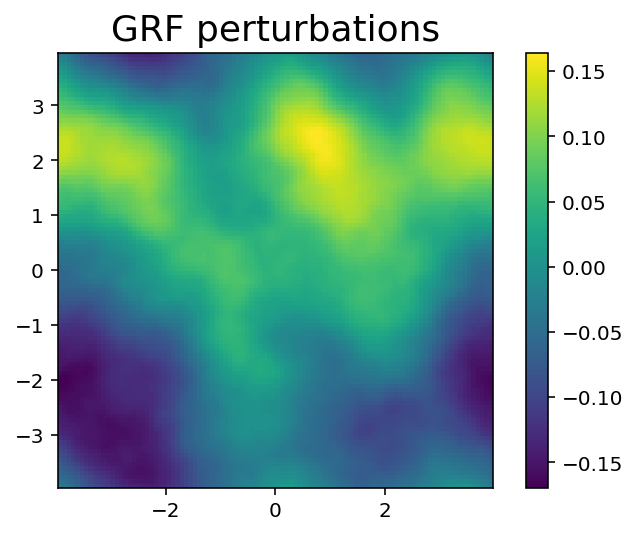

In [7]:
# Potential perturbation as a GRF with power spectrum P(k)=Ak^beta
logA = -3.8
beta = -5
box_length = 2 * np.pi * npix * pix_scl
pb = pbox.PowerBox(N=npix, dim=2, pk=(lambda k: 10**logA * k**beta), boxlength=box_length, seed=42)
psi_pert_highres = pb.delta_x()

plt.title("GRF perturbations", fontsize=FS)
plt.imshow(psi_pert_highres, origin='lower', extent=extent)
plt.colorbar()
plt.show()

In [8]:
# True lens mass model
true_lens_mass_model_list = ['SIE', 'PIXELATED']
true_lens_mass_model = LensModel(true_lens_mass_model_list)
kwargs_true_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                         {'pixels': psi_pert_highres}]

# Hybrid lens mass model
hybrid_lens_mass_model_list = ['SIE', 'PIXELATED']
kwargs_pixelated_lens = {'pixel_scale_factor': potential_scale_factor, 'conserve_extent': True}
hybrid_lens_mass_model = LensModel(hybrid_lens_mass_model_list,
                                   kwargs_pixelated=kwargs_pixelated_lens)

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

In [9]:
kwargs_numerics = {'supersampling_factor': 1}
pixel_grid_copy = deepcopy(pixel_grid)

# True image model
true_lens_image = LensImage(pixel_grid, psf, noise_class=noise_hybrid,
                                lens_model_class=true_lens_mass_model,
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)

# Hybrid image model for fitting
hybrid_lens_image = LensImage(pixel_grid_copy, psf, noise_class=noise_hybrid,
                                lens_model_class=hybrid_lens_mass_model,
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)

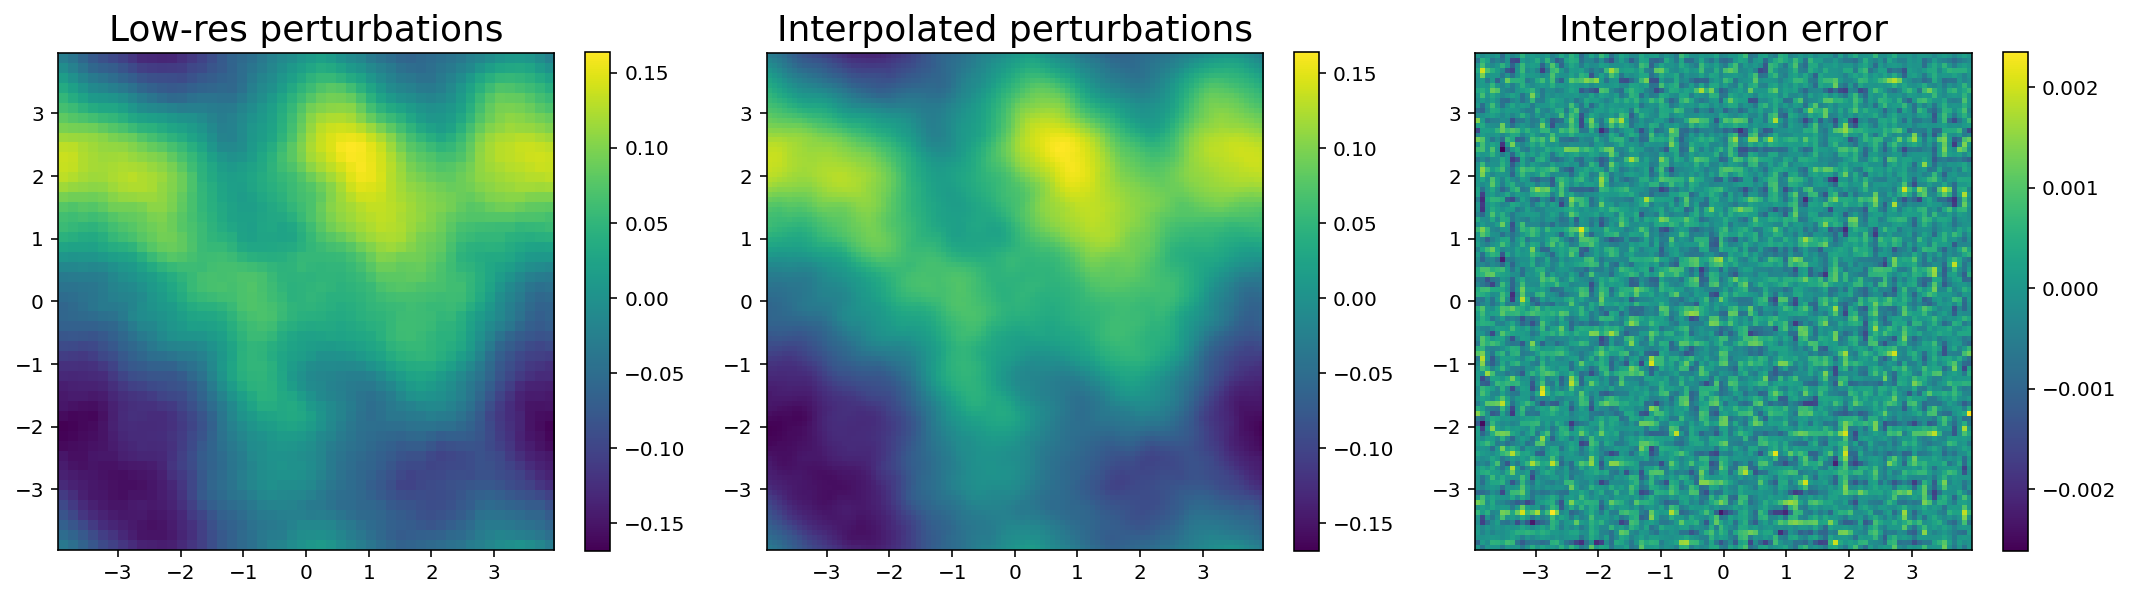

In [10]:
# Extract coordinate grids for pixelated potential
x_grid_lowres, y_grid_lowres = hybrid_lens_image.Grid.model_pixel_coordinates('lens')

# Extract the true perturbation potential on original and low-res grids
psi_grid_true = true_lens_image.LensModel.potential(x_grid, y_grid, kwargs_true_lens_mass, k=1)
psi_grid_true_lowres = true_lens_image.LensModel.potential(x_grid_lowres, y_grid_lowres, kwargs_true_lens_mass, k=1)

# Set the hybrid lens mass model parameters
kwargs_hybrid_lens_mass = [kwargs_true_lens_mass[0],
                           {'pixels': psi_grid_true_lowres}]  # Transpose so that image_model works properly

# Test interpolating the low-res hybrid model to the original grid
psi_grid_interp = hybrid_lens_image.LensModel.potential(x_grid, y_grid, kwargs_hybrid_lens_mass, k=1)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
img1 = axes[0].imshow(psi_grid_true_lowres, origin='lower', extent=extent)
axes[0].set_title("Low-res perturbations", fontsize=FS)
img2 = axes[1].imshow(psi_grid_interp, origin='lower', extent=extent)
axes[1].set_title("Interpolated perturbations", fontsize=FS)
img3 = axes[2].imshow(psi_grid_true - psi_grid_interp, origin='lower', extent=extent)
axes[2].set_title("Interpolation error", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

### Image model

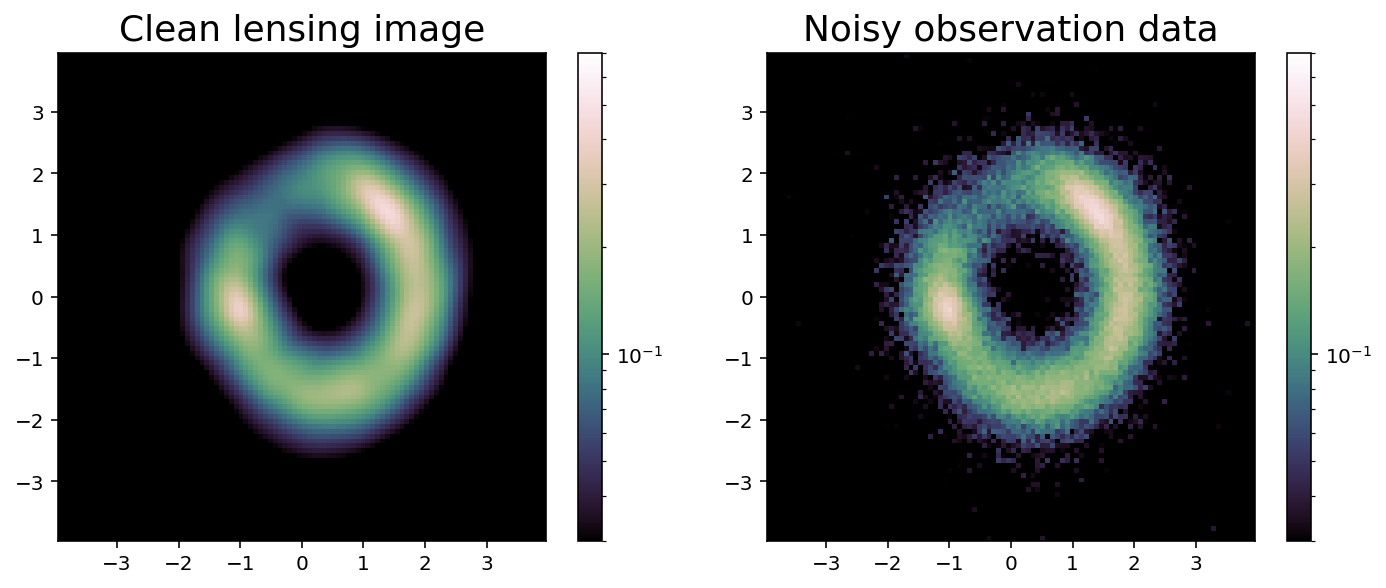

In [11]:
# Generate a lensed image based on source and lens models
image = true_lens_image.model(kwargs_lens=kwargs_true_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)


# Observed noisy data
data = true_lens_image.simulation(kwargs_lens=kwargs_true_lens_mass,
                             kwargs_source=kwargs_source_light,
                             kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

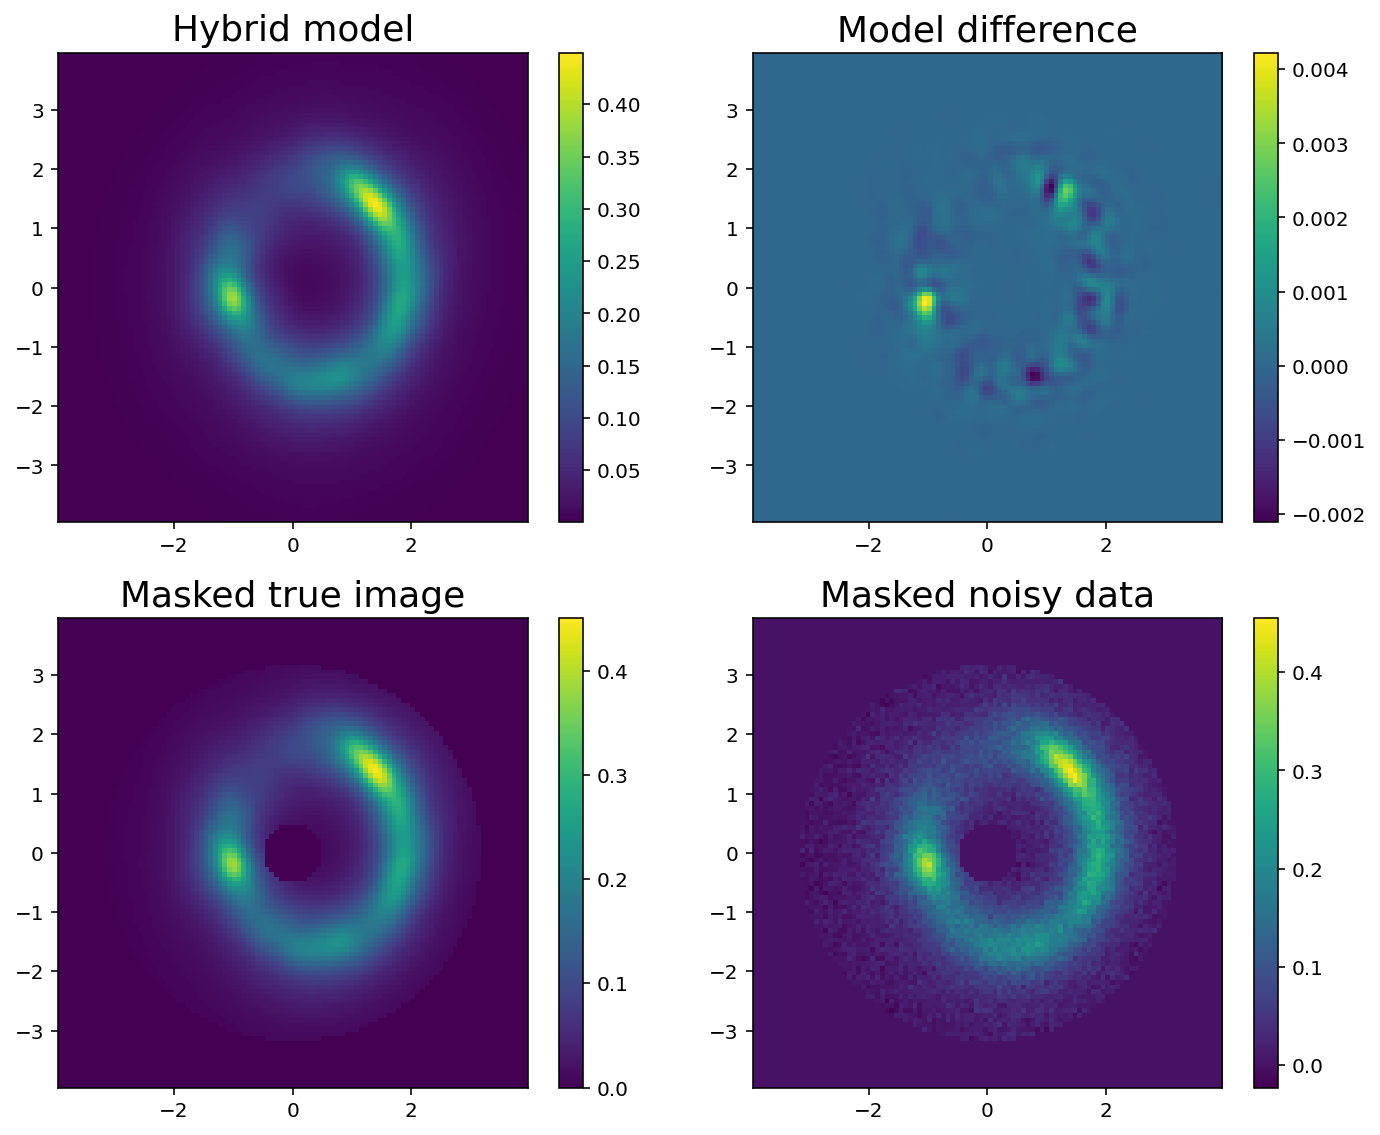

In [12]:
# Test the hybrid model with the true low-res perturbation grid
hybrid_image = hybrid_lens_image.model(kwargs_lens=kwargs_hybrid_lens_mass,
                                        kwargs_source=kwargs_source_light,
                                        kwargs_lens_light=kwargs_lens_light)

# Generate a mask
rmin = 0.5
rmax = 3.2
# Original grid
radius = np.hypot(x_grid, y_grid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(float)
# Low-res grid
radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2), (ax3, ax4) = axes
img1 = ax1.imshow(hybrid_image, origin='lower', extent=extent)
img2 = ax2.imshow(image - hybrid_image, origin='lower', extent=extent)
img3 = ax3.imshow(mask * image, origin='lower', extent=extent)
img4 = ax4.imshow(mask * data, origin='lower', extent=extent)
ax1.set_title("Hybrid model", fontsize=FS)
ax2.set_title("Model difference", fontsize=FS)
ax3.set_title("Masked true image", fontsize=FS)
ax4.set_title("Masked noisy data", fontsize=FS)
for img, ax in zip((img1, img2, img3, img4), np.ravel(axes)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

In [13]:
def perturb_values(kwargs_params, level=0.2, seed=29):
    np.random.seed(seed)
    for model_key, kwargs_model in kwargs_params.items():
        for idx_profile, kwargs_profile in enumerate(kwargs_model):
            for param_name, param_value in kwargs_profile.items():
                if param_name == 'pixels':
                    continue
                if param_value != 0.:
                    random_perturb = level * param_value * np.random.randn()
                else:
                    random_perturb = level * 1e-3 * np.random.randn()
                kwargs_params[model_key][idx_profile][param_name] += random_perturb
    return kwargs_params

## Fit smooth parameters only

Number of parameters: 12


minimize.BFGS:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at initial values: 101694.97
Loss at true values: 8060.828


minimize.BFGS: 100%|██████████| 1/1 [00:14<00:00, 14.52s/it]

Runtime: 14.52161693572998
Loss at best-fit: 6259.159


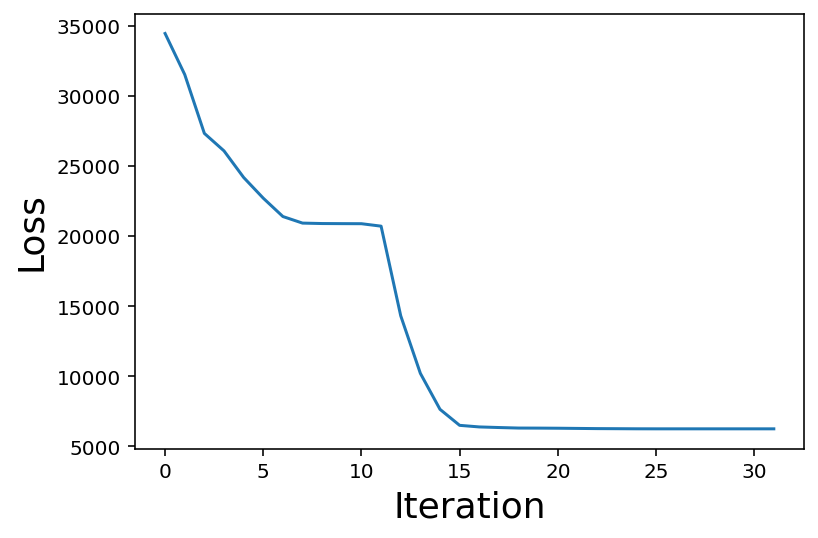

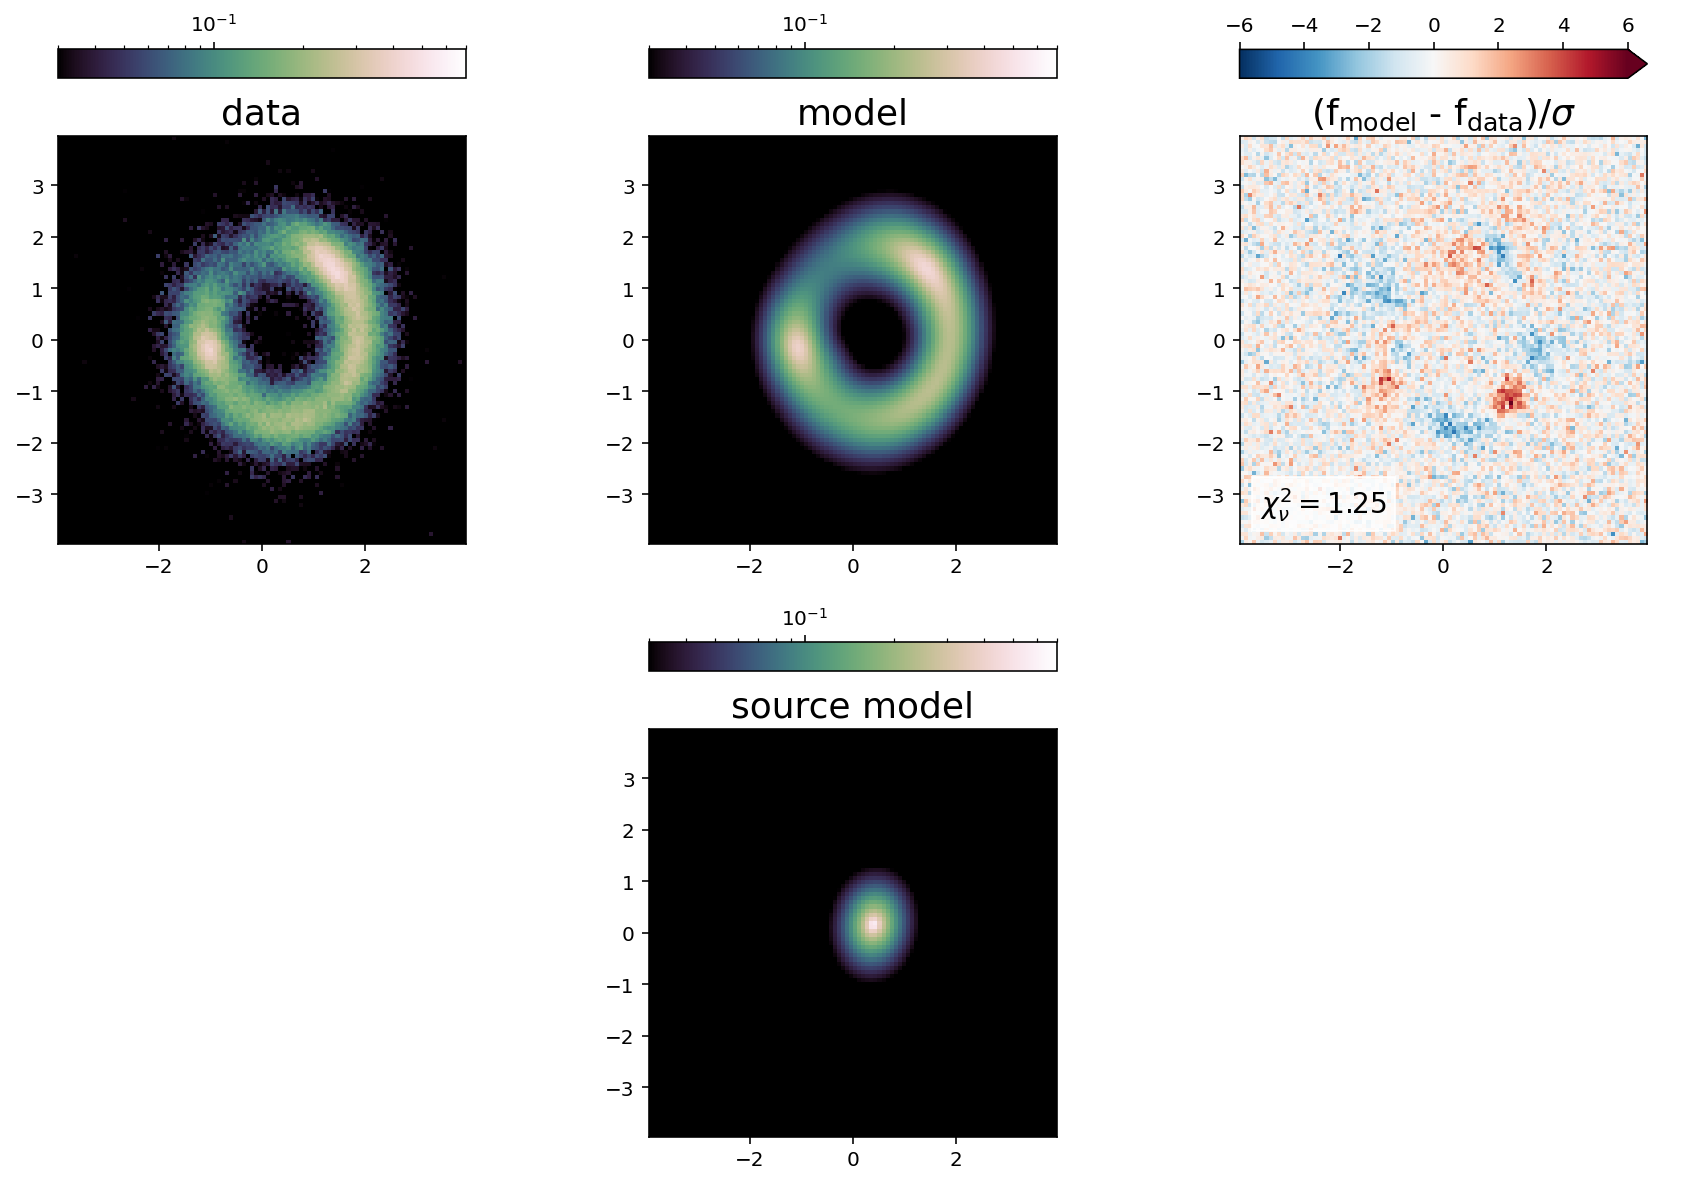

In [14]:
kwargs_true_perturbed = perturb_values(deepcopy({'kwargs_lens': kwargs_true_lens_mass, 
                                                 'kwargs_source': kwargs_source_light}),
                                       level=0.1, seed=8)


psi_grid_init = 1e-8 * np.ones_like(psi_grid_true_lowres)
kwargs_init = {
    'kwargs_lens': [kwargs_true_perturbed['kwargs_lens'][0], {}],
    'kwargs_source': kwargs_true_perturbed['kwargs_source'],
}
kwargs_fixed = {
    'kwargs_lens': [{}, {'pixels': psi_grid_init}],
    'kwargs_source': [{}],
}
parameters = Parameters(hybrid_lens_image, kwargs_init, kwargs_fixed)
print("Number of parameters:", parameters.num_parameters)

kwargs_true = {
    'kwargs_lens': kwargs_hybrid_lens_mass, 
    'kwargs_source': kwargs_source_light,
}
p_init = parameters.initial_values()
p_true = parameters.kwargs2args(kwargs_true)

# Create loss
loss_smooth = Loss(data, hybrid_lens_image, parameters, likelihood_type='chi2', prior_terms=None)

print("Loss at initial values:", loss_smooth(p_init))
print("Loss at true values:", loss_smooth(p_true))

optimizer_smooth = Optimizer(loss_smooth, parameters)

best_fit, logL, extra_fields, runtime \
    = optimizer_smooth.minimize(method='BFGS', restart_from_init=True, maxiter=None)

print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_smooth(best_fit))

kwargs_smooth_fit = deepcopy(parameters.best_fit_values(as_kwargs=True))

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

plotter.set_data(data)

fig = plotter.model_summary(hybrid_lens_image, kwargs_smooth_fit)
plt.show()

In [15]:
fim_cov = FisherCovariance(parameters, loss_smooth)
fim_cov.compute_fisher_information()
cov_matrix_smooth = fim_cov.covariance_matrix

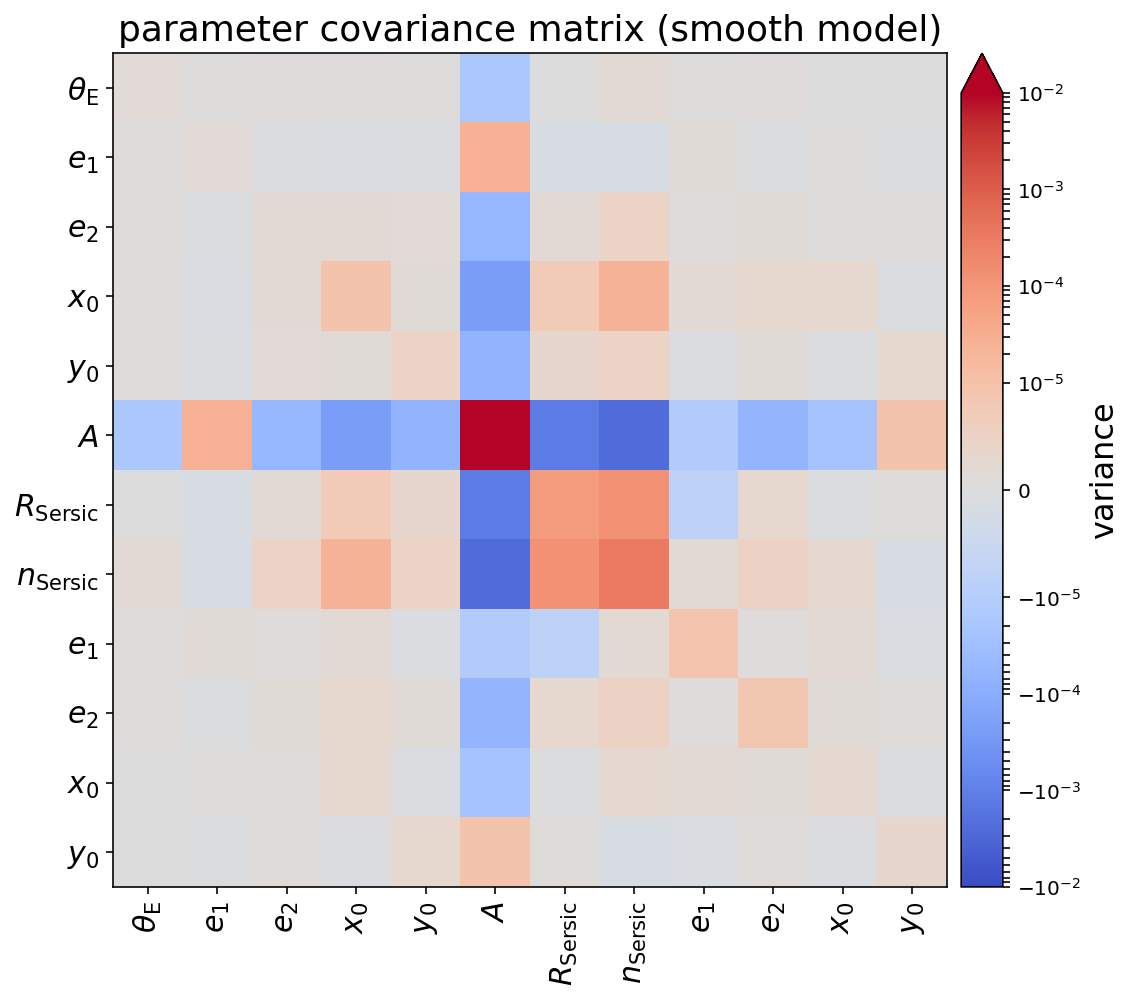

In [16]:
vmax = 1e-2
vmin = -vmax

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
ax = axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r"parameter covariance matrix (smooth model)", fontsize=18)
ax.set_xticks(range(len(parameters.names)))
ax.set_xticklabels(parameters.symbols, rotation=90, fontsize=15)
ax.set_yticks(range(len(parameters.names)))
ax.set_yticklabels(parameters.symbols, rotation=0, fontsize=15)
im = ax.imshow(cov_matrix_smooth, origin='upper',
               norm=SymLogNorm(linthresh=0.00001, linscale=1, vmin=vmin, vmax=vmax),
               #norm=TwoSlopeNorm(0),
               cmap='coolwarm')
cb = plot_util.nice_colorbar_residuals(im, cov_matrix_smooth, vmin=vmin, vmax=vmax, size='5%',
                             label=r"variance", fontsize=16, 
                             #colorbar_kwargs={'ticks': [-1e3, -1e0, -1e-3, 0, +1e-3, +1e0, +1e3]}
                            )
#cb.ax.tick_params(labelsize=12)

fig.tight_layout()
plt.show()

In [17]:
# relative error per parameter
std_dev_smooth_fim = np.sqrt(np.abs(np.diag(cov_matrix_smooth)))
print(parameters.names)
print("relative errors:", std_dev_smooth_fim/np.abs(best_fit)*100)

['theta_E', 'e1', 'e2', 'center_x', 'center_y', 'amp', 'R_sersic', 'n_sersic', 'e1', 'e2', 'center_x', 'center_y']
relative errors: [ 0.07541141  0.87803497  2.3740192   5.45074154 18.84003063  1.76298233
  1.0131671   1.17130827  2.36514734  9.241167    0.36433316  1.10888109]


## Fit the lens potential perturbation as a pixelated grid

_Fixing the smooth parameters to groundtruth_

### Parameters

Here we select which parameters to optimise, which one are fixed, lower/upper bounds (treated as "uniform" prior).

In [18]:
npix_lowres = npix // kwargs_pixelated_lens['pixel_scale_factor']
masked_lower = -10.*np.ones(npix_lowres**2)*mask_lowres.flatten()
masked_upper = +10.*np.ones(npix_lowres**2)*mask_lowres.flatten()

kwargs_prior = {
    'kwargs_lens': [{}, {'pixels': ['uniform', masked_lower, masked_upper]}],
    'kwargs_source': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [kwargs_true_lens_mass[0], {}],
    'kwargs_source': kwargs_source_light,
    #'kwargs_lens': [kwargs_true_perturbed['kwargs_lens'][0], {}],
    #'kwargs_source': kwargs_true_perturbed['kwargs_source'],
}
parameters.update_fixed(kwargs_fixed, kwargs_prior=kwargs_prior)
print("Number of parameters:", parameters.num_parameters)

print(parameters.prior_types[0])
#print(parameters.bounds)

Number of parameters: 2500
uniform


#### Bounds for $\delta\psi$

_This are actually not used during optimization._

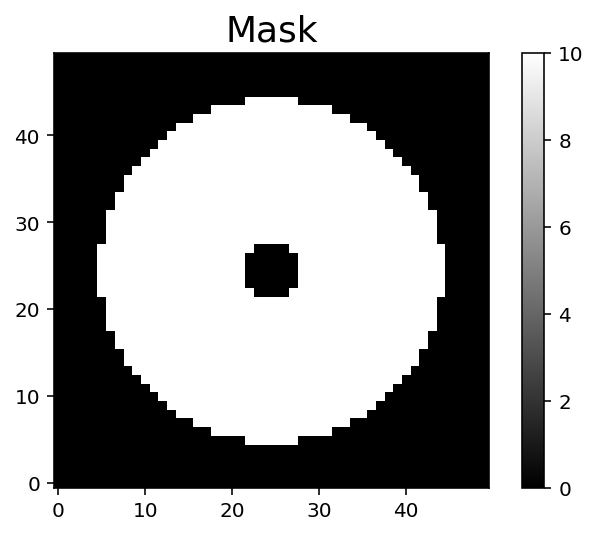

In [19]:
plt.title("Mask", fontsize=FS)
plt.imshow(parameters.bounds[1].reshape(npix_lowres, npix_lowres), origin='lower', cmap='gray')
plt.colorbar()
plt.show()

# Fit the perturbed pixelated potential

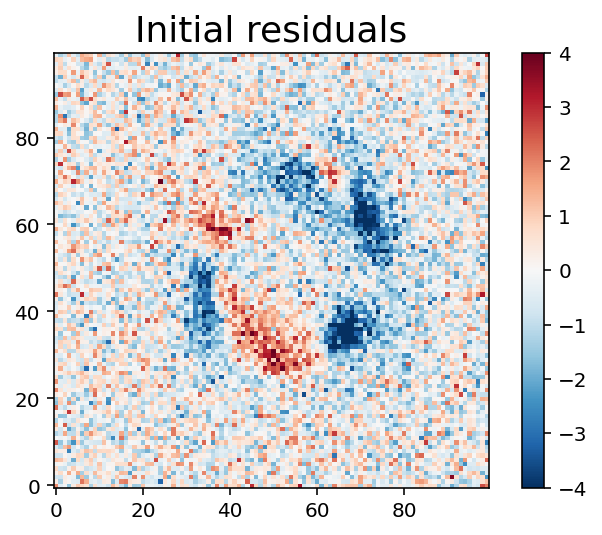

In [20]:
hybrid_image_init = hybrid_lens_image.model(**parameters.initial_values(as_kwargs=True))

plt.title("Initial residuals", fontsize=FS)
plt.imshow((data - hybrid_image_init) / np.sqrt(true_lens_image.Noise.C_D), origin='lower', cmap='RdBu_r', vmin=-4, vmax=4)
plt.colorbar()
plt.show()

### Starlet regularization

#### Load pre-estimated potential noise map

In [21]:
(pot_noise_st, pot_noise_bl), _ = model_util.data_noise_to_wavelet_potential(hybrid_lens_image, 
                                                      parameters.initial_values(as_kwargs=True),
                                                      wavelet_type_list=['starlet', 'battle-lemarie-3'], 
                                                      num_samples=5000, seed=8, verbose=True)

compute DsDpsi: 0.6075260639190674
compute B: 3.557034969329834
construct D: 0.1006317138671875
loop over MC samples for wavelet 'starlet': 12.50084376335144
loop over MC samples for wavelet 'battle-lemarie-3': 14.918733835220337


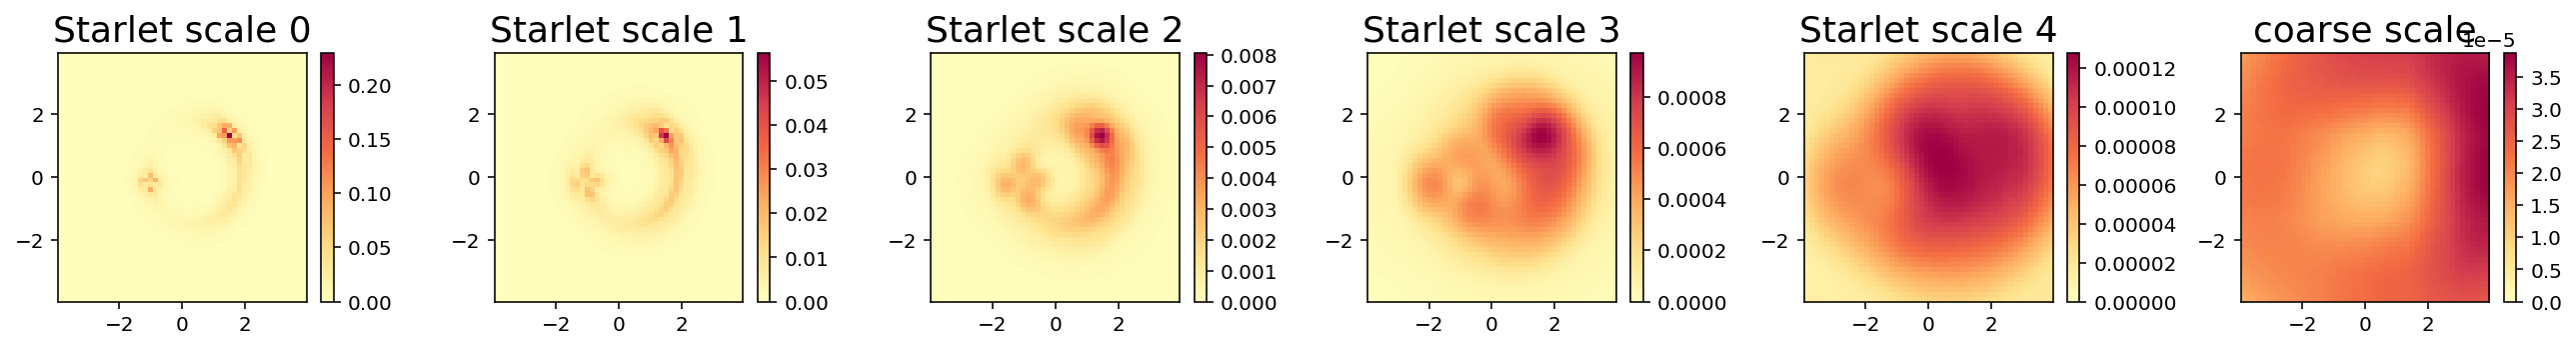

In [22]:
fig, axes = plt.subplots(1, pot_noise_st.shape[0], figsize=(18, 4))
for k in range(pot_noise_st.shape[0]):
    ax = axes[k]
    if k == pot_noise_st.shape[0]-1:
        ax.set_title(f"coarse scale", fontsize=FS)
    else:
        ax.set_title(f"Starlet scale {k}", fontsize=FS)
    im = ax.imshow(pot_noise_st[k], extent=extent, cmap='Spectral_r', norm=TwoSlopeNorm(0))
    plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

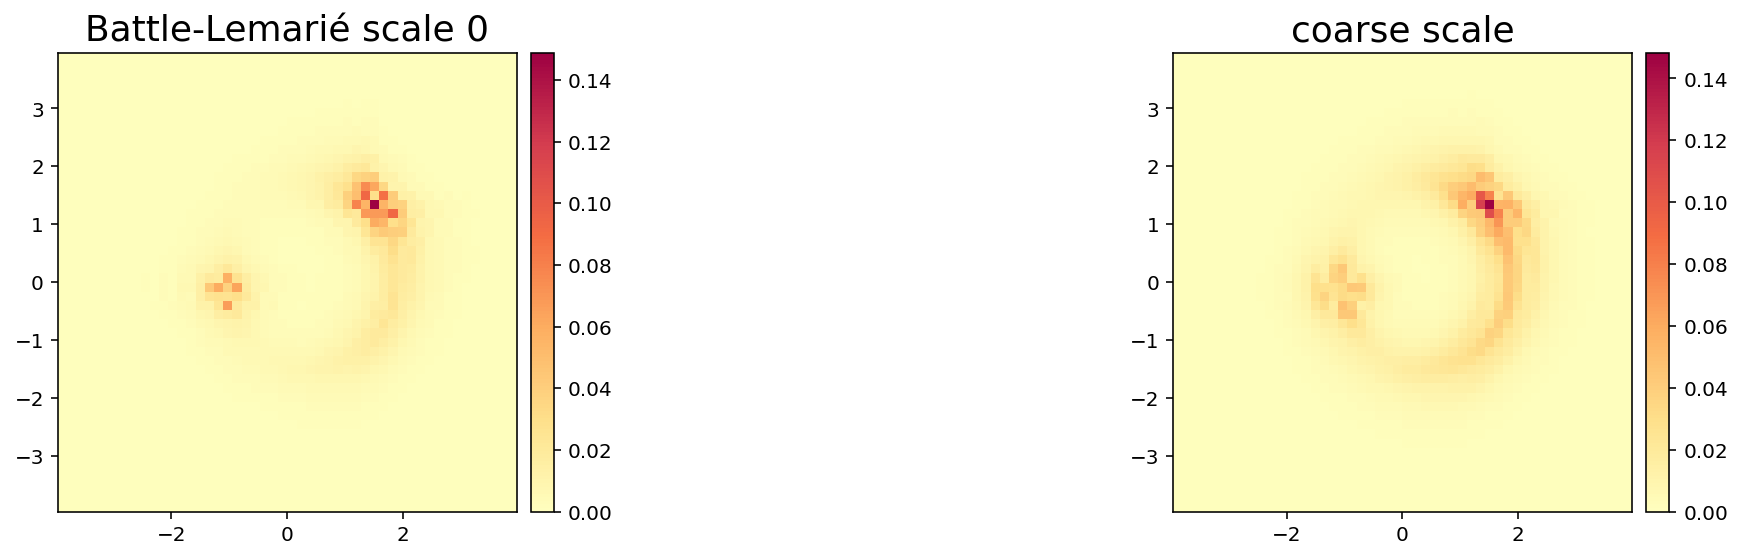

In [23]:
fig, axes = plt.subplots(1, pot_noise_bl.shape[0], figsize=(18, 4))
for k in range(pot_noise_bl.shape[0]):
    ax = axes[k]
    if k == pot_noise_bl.shape[0]-1:
        ax.set_title(f"coarse scale", fontsize=FS)
    else:
        ax.set_title(f"Battle-Lemarié scale {k}", fontsize=FS)
    im = ax.imshow(pot_noise_bl[k], extent=extent, cmap='Spectral_r', norm=TwoSlopeNorm(0))
    plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

In [24]:
#print("mean level:", np.mean(dpsi_noise_map1a), np.mean(dpsi_noise_map2))
#print("mean level within mask:", np.mean(dpsi_noise_map1a[mask_lowres == 1.]), np.mean(dpsi_noise_map2[mask_lowres == 1.]))

#### Create the loss function, including $\ell_1$-norm + starlet regularization

In [30]:
# Create loss
loss = Loss(data, hybrid_lens_image, parameters, 
            likelihood_type='l2_norm',
            regularization_terms=[
                'l1_starlet_potential', 
                'l1_battle_potential'
            ], 
            regularization_strengths=[
                (3, 3),
                5
            ],
            regularization_weights=[
                pot_noise_st, #_data, #_datamodel, 
                pot_noise_bl, #_data, #_datamodel
            ],
            prior_terms=None)

print("Loss at initial values:", loss(parameters.initial_values()))

Loss at initial values: 1.1490316


#### Launch optimization

In [32]:
optimizer = Optimizer(loss, parameters)

optimizer_type = 'optax'

if optimizer_type == 'minimize':
    best_fit, logL, extra_fields, runtime \
        = optimizer.minimize(method='BFGS', 
                             restart_from_init=True, 
                             maxiter=None)
    
elif optimizer_type == 'optax':
    best_fit, logL, extra_fields, runtime \
        = optimizer.optax(algorithm='adabelief', 
                          restart_from_init=True, 
                          init_learning_rate=1e-3,
                          max_iterations=500)

print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss(best_fit))

optax.adabelief: 100%|██████████| 500/500 [00:27<00:00, 18.16it/s]


Runtime: 27.538426160812378
Loss at best-fit: 0.76636255


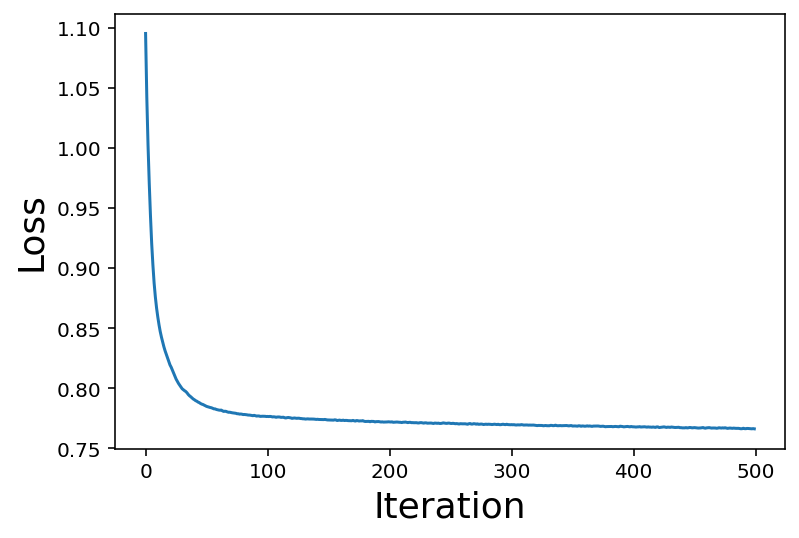

In [33]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

delta_psi shift by mean values: -0.01528826 0.029746974


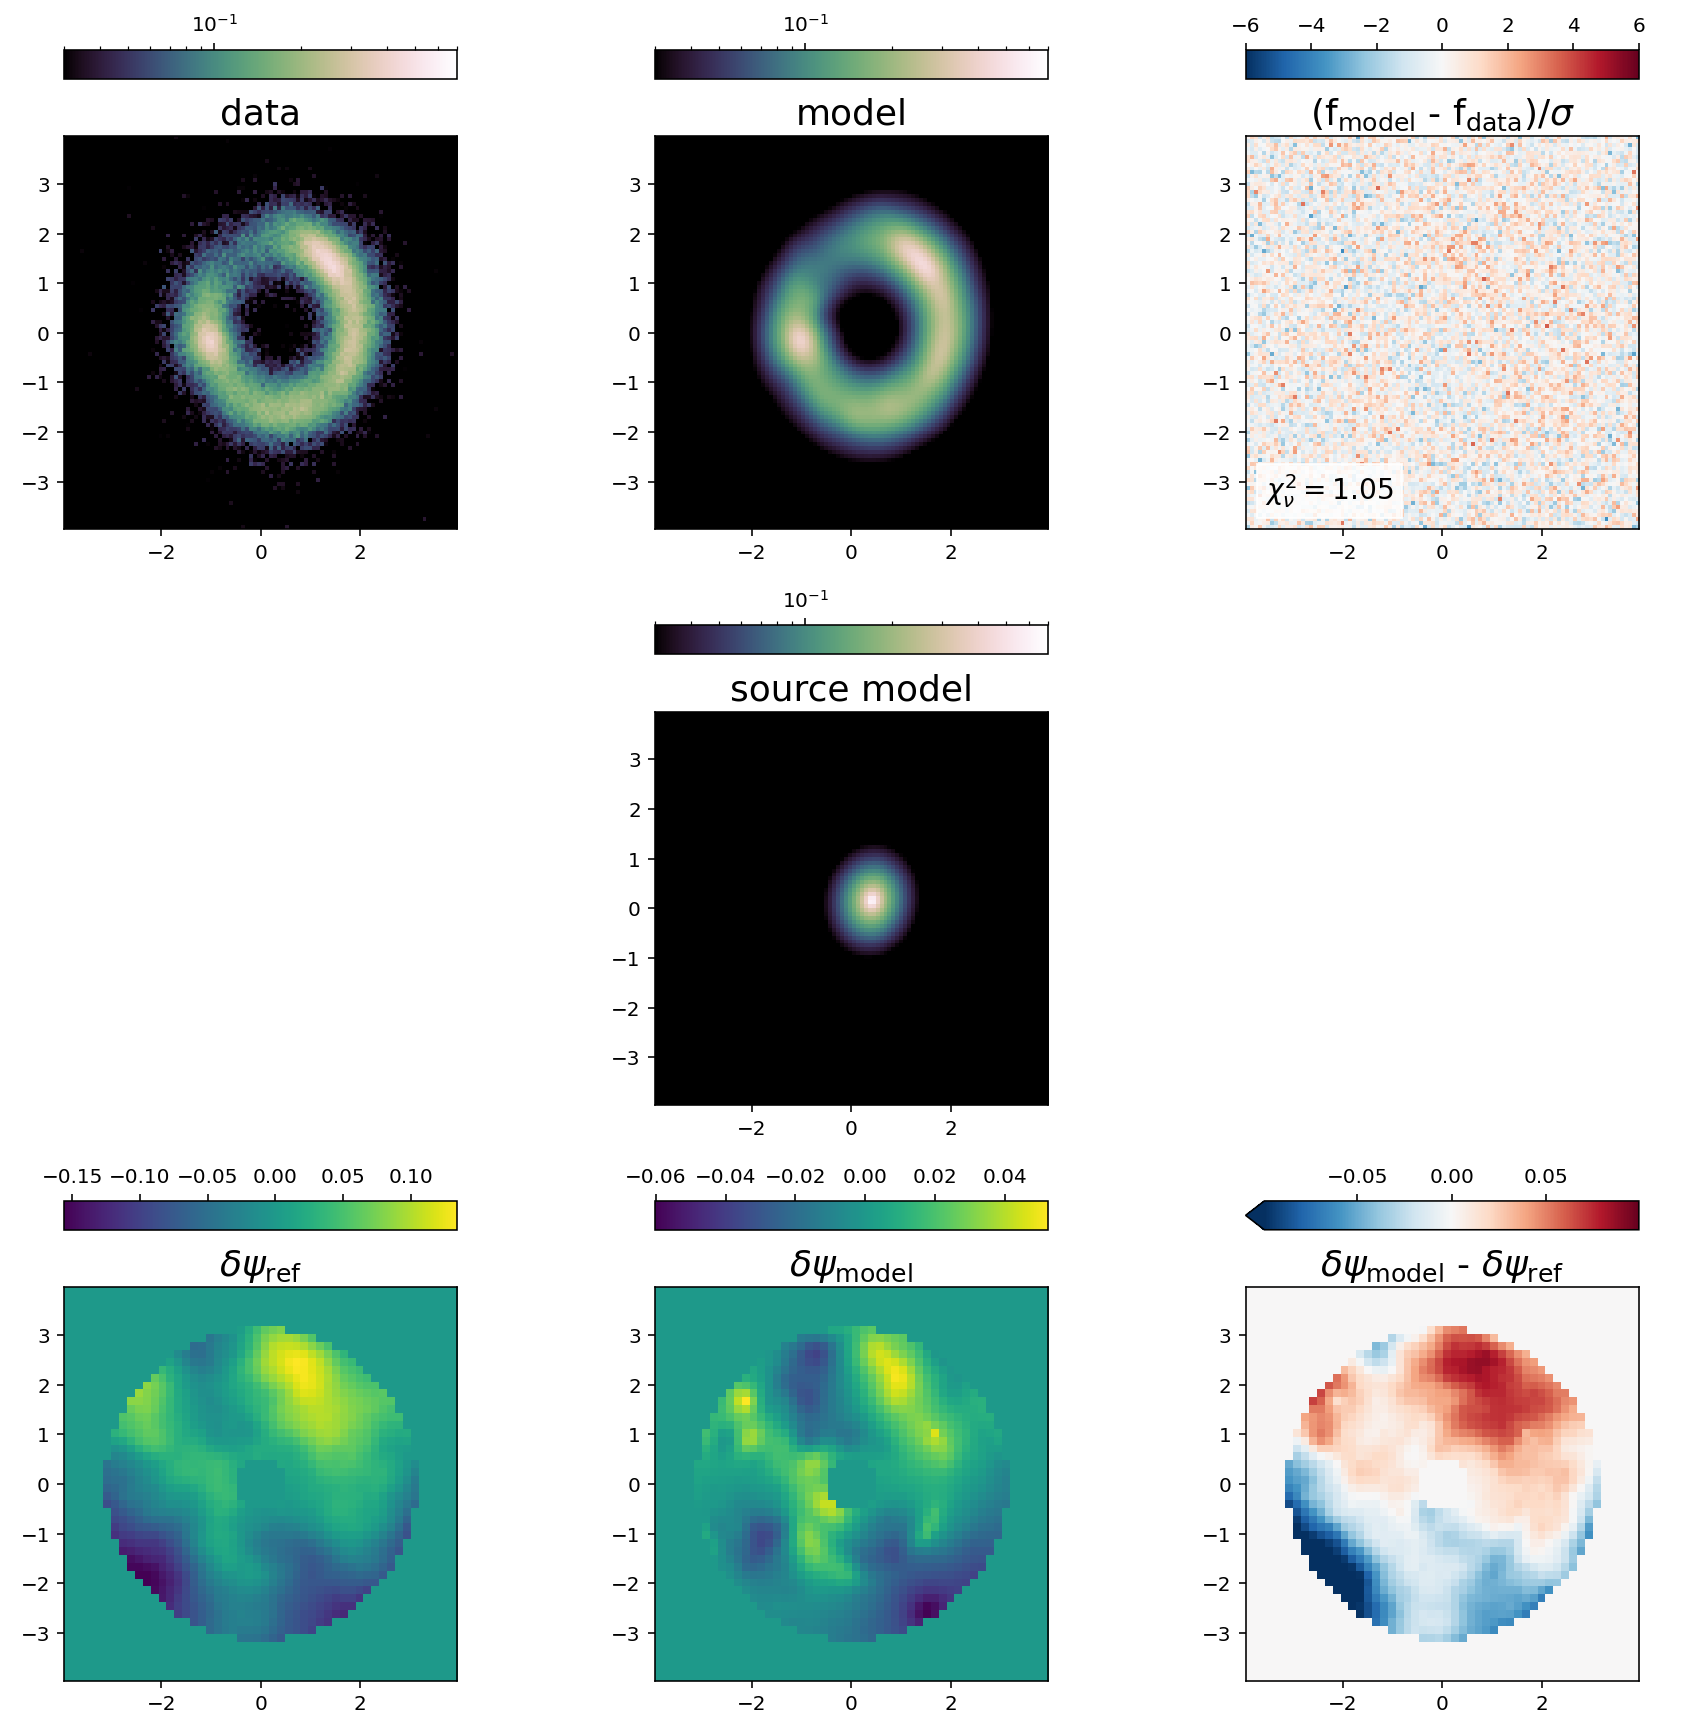

In [34]:
plotter.set_ref_pixelated_potential(psi_grid_true_lowres)
plotter.set_data(data)

kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
fig = plotter.model_summary(hybrid_lens_image, kwargs_final,
                            show_lens_potential=True, 
                            show_lens_others=False, 
                            potential_mask=mask_lowres,
                            shift_pixelated_potential='mean')
plt.show()

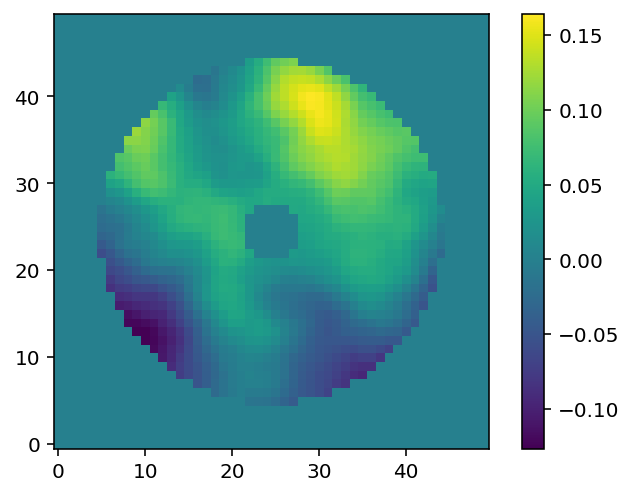

Perturbation level wrt macro potential: 1.751 [%]
Data max SNR [24.979847]


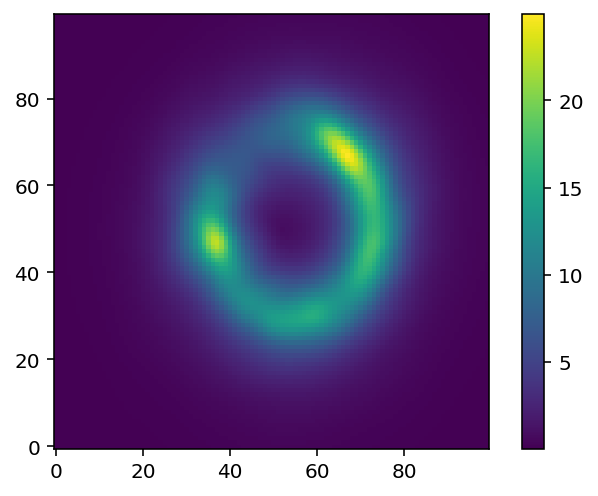

In [29]:
# here we compute the relative magnitude of potential perturbations
# w.r.t. to the macro potential within the mask

# Extract coordinate grids for pixelated potential
x_grid_fit, y_grid_fit = hybrid_lens_image.Grid.model_pixel_coordinates('lens')

# Extract the true perturbation potential on fitted grid
psi_grid_input_fitgrid = hybrid_lens_image.LensModel.potential(x_grid_fit, y_grid_fit, kwargs_hybrid_lens_mass, k=-1)

macro_pot_input_fitgrid = true_lens_image.LensModel.potential(x_grid_fit, y_grid_fit, 
                                                   kwargs_true_lens_mass, k=[True, False])
macro_pot_input_fitgrid = np.array(macro_pot_input_fitgrid)
macro_pot_input_fitgrid[macro_pot_input_fitgrid < 1e-1] = 1e-1

psi_relative = psi_grid_input_fitgrid / macro_pot_input_fitgrid

plt.imshow(psi_grid_input_fitgrid * mask_lowres, origin='lower')
plt.colorbar()
plt.show()

psi_pert_perc = np.abs(psi_relative[mask_lowres==1]).mean() * 100

print(f"Perturbation level wrt macro potential: {psi_pert_perc:.3f} [%]")

snr_map = np.abs(image) / np.sqrt(true_lens_image.Noise.C_D)
print("Data max SNR", snr_map[image == image.max()] )

plt.imshow(snr_map, origin='lower')
plt.colorbar()
plt.show()